# Sentiment Analysis

**Task**: Perform Sentiment Analysis for the comments from customers who did on-line shopping with ICONIC.

## Import the necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer

matplotlib.style.use('ggplot')
%matplotlib inline

## 1. Load the data

In [2]:
raw_data = pd.read_excel("./NPS_Comments.xlsx", header=0)
raw_data.head()

,Device,Response ID,Time Started,Why would you hesitate to recommend THE ICONIC to a friend or colleague?,Why would you recommend THE ICONIC to a friend or colleague?,Site/App: how satisfied were you with the following?: What would make you use our app/msite/website more?,Product Range: how satisfied were you with the following?: How can we improve our product range?,"Product Range: were you looking for a specific style or brand and could not find it? If so, please provide details below",Delivery: how satisfied were you with the following?: How can we improve our delivery service?,Customer service: how satisfied were you with the following?: How could we improve our customer service process?,Returns: how satisfied were you with the following?: How can we improve our returns experience?
0,Msite,3058,2016-11-23 13:27:43,NaN,"Great variety of products, fast delivery,easy ...",NaN,NaN,NaN,NaN,NaN,NaN
1,Msite,3761,2016-12-03 12:54:00,NaN,fast delivery,NaN,NaN,NaN,NaN,NaN,NaN
2,Msite,4133,2016-12-08 00:04:50,NaN,Value for money,NaN,NaN,No,NaN,NaN,NaN
3,Msite,4134,2016-12-08 00:34:02,NaN,Great customer service,NaN,NaN,NaN,NaN,NaN,NaN
4,Msite,4135,2016-12-08 01:00:43,NaN,Great service,NaN,NaN,NaN,NaN,NaN,Return hasn't happened yet - just picking up t...


## 2. Explore the data and clean the data

### 2.1 Check the number of comments for each question

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5744 entries, 0 to 5743
Data columns (total 11 columns):
Device                                                                                                                        5744 non-null object
Response ID                                                                                                                   5744 non-null int64
Time Started                                                                                                                  5744 non-null datetime64[ns]
Why would you hesitate to recommend THE ICONIC to a friend or colleague?                                                      365 non-null object
Why would you recommend THE ICONIC to a friend or colleague?                                                                  3547 non-null object
Site/App: how satisfied were you with the following?: What would make you use our app/msite/website more?                     1096 non-null object
Produ

In [4]:
print('These comments are received from customers between {0} and {1}.'.format(\
    raw_data['Time Started'].min().strftime('%Y-%m-%d %H:%M:%S'), raw_data['Time Started'].max().strftime('%Y-%m-%d %H:%M:%S')))

These comments are received from customers between 2016-10-07 23:09:00 and 2017-01-06 23:56:00.


It is better to have short column names. So I change the column names with a dict to map to the original questions.

In [5]:
ids = range(8)
questions = {'Q'+str(id+1): q.strip() for id, q in zip(ids, raw_data.columns[3:])}
questions

{'Q1': 'Why would you hesitate to recommend THE ICONIC to a friend or colleague?',
 'Q2': 'Why would you recommend THE ICONIC to a friend or colleague?',
 'Q3': 'Site/App: how satisfied were you with the following?: What would make you use our app/msite/website more?',
 'Q4': 'Product Range: how satisfied were you with the following?: How can we improve our product range?',
 'Q5': 'Product Range: were you looking for a specific style or brand and could not find it? If so, please provide details below',
 'Q6': 'Delivery: how satisfied were you with the following?: How can we improve our delivery service?',
 'Q7': 'Customer service: how satisfied were you with the following?: How could we improve our customer service process?',
 'Q8': 'Returns: how satisfied were you with the following?: How can we improve our returns experience?'}

In [6]:
raw_data.columns = ['Device', 'Response ID', 'Time Started'] + list(sorted(questions.keys()))
# raw_data.head()

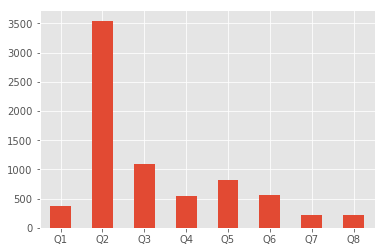

In [7]:
raw_data.iloc[:, 3:].count().plot(kind='bar', rot=0)

It shows that there are most comments for Q2 'Why would you recommend THE ICONIC to a friend or colleague?', while there are lest comments for Q7 'Customer service: how satisfied were you with the following?: How could we improve our customer service process?'.

### 2.2 Combine all comments

To make it simple, I concatenate all the comments from each record into one. Based on the combined comments, I can perform Sentiment Analysis to classify the comments as positive or negative.

In [8]:
def concat_comment(args):
    result = ''
    for arg in args:
        if isinstance(arg, str) and len(arg) > 0:
            result += ' ' + arg
    return result.strip()

In [9]:
concat_comment(['s1', 's2', np.NaN])

's1 s2'

In [10]:
comments = raw_data.ix[:, :3]
comments['Comment'] = raw_data[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].apply(concat_comment, axis=1)
comments.head(10)

,Device,Response ID,Time Started,Comment
0,Msite,3058,2016-11-23 13:27:43,"Great variety of products, fast delivery,easy ..."
1,Msite,3761,2016-12-03 12:54:00,fast delivery
2,Msite,4133,2016-12-08 00:04:50,Value for money No
3,Msite,4134,2016-12-08 00:34:02,Great customer service
4,Msite,4135,2016-12-08 01:00:43,Great service Return hasn't happened yet - jus...
5,Msite,4136,2016-12-08 02:00:46,
6,Msite,4137,2016-12-08 02:30:14,Fast shipping
7,Msite,4138,2016-12-08 02:58:01,
8,Msite,4139,2016-12-08 02:58:02,Great service and fast shipping It was my firs...
9,Msite,4140,2016-12-08 03:11:55,


Then calculate the length for each comment.

In [11]:
comments['Length'] = comments['Comment'].apply(lambda s: len(s.split()))
comments.head(10)

,Device,Response ID,Time Started,Comment,Length
0,Msite,3058,2016-11-23 13:27:43,"Great variety of products, fast delivery,easy ...",11
1,Msite,3761,2016-12-03 12:54:00,fast delivery,2
2,Msite,4133,2016-12-08 00:04:50,Value for money No,4
3,Msite,4134,2016-12-08 00:34:02,Great customer service,3
4,Msite,4135,2016-12-08 01:00:43,Great service Return hasn't happened yet - jus...,20
5,Msite,4136,2016-12-08 02:00:46,,0
6,Msite,4137,2016-12-08 02:30:14,Fast shipping,2
7,Msite,4138,2016-12-08 02:58:01,,0
8,Msite,4139,2016-12-08 02:58:02,Great service and fast shipping It was my firs...,36
9,Msite,4140,2016-12-08 03:11:55,,0


The records without comments are dropped.

In [12]:
clean_comments = comments[comments['Length'] > 0].copy()
print('There are total {0} records without comments'.format(len(comments) - len(clean_comments)))

There are total 1791 records without comments


We can inspect the distribution of length of comments.

In [13]:
clean_comments['Length'].describe()

count    3953.000000
mean       16.190235
std        23.016590
min         1.000000
25%         4.000000
50%         8.000000
75%        19.000000
max       441.000000
Name: Length, dtype: float64

Histogram and Boxplot for the length of comments.

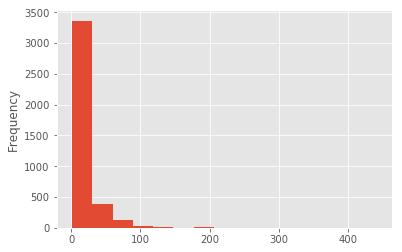

In [14]:
clean_comments['Length'].plot(kind='hist', bins=15)

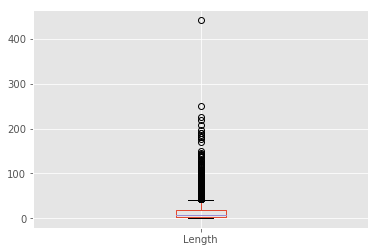

In [15]:
clean_comments['Length'].plot(kind='box')

The majority of comments are within 20 words. However, there is a very enthusiastic customer who commented more than 400 words. Let's have a look what the customer commented.

In [16]:
lengthy_ix = clean_comments[clean_comments['Length'] > 400].index
raw_data.ix[lengthy_ix,:]

,Device,Response ID,Time Started,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
5513,Desktop,74371,2017-01-03 07:21:00,NaN,Resealable pouch! free delivery easy returns,I find searching the site laborious please do ...,Some of the items have been terrific but some ...,High quality good shaped t-shirts and tanks NO...,I am very satisfied with your delivery service...,The paypal function would not activate on the ...,NaN


## 3. Sentiment Analysis with textblob library

There are no output labels for THE ICONIC data. I use [TextBlob library](https://textblob.readthedocs.io) to perform Sentiment Analysis.
>"TextBlob is a Python (2 and 3) library for processing textual data. It provides a consistent API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, and more."

There are two types of sentiment analysis provided by this library.
* **PatternAnalyzer**: based on the pattern library.
* **NaiveBayesAnalyzer**: an NLTK classifier trained on a movie reviews corpus.

### 3.1 Sentiment polarity
The polarity score is a float within the range [-1.0, 1.0] where -1.0 is very negative and 1.0 is very positive. The details behind how to calculate the sentiment polarity can be found in [this web page](http://planspace.org/20150607-textblob_sentiment/). 

In [17]:
def senti_polarity(comment):
    s = TextBlob(comment)
    return s.sentiment.polarity

In [18]:
clean_comments['Sentiment polarity'] = clean_comments['Comment'].apply(senti_polarity)

The distribution of Sentiment Polarity is

In [21]:
clean_comments['Sentiment polarity'].describe()

count    3953.000000
mean        0.360464
std         0.272684
min        -1.000000
25%         0.200000
50%         0.383333
75%         0.522222
max         1.000000
Name: Sentiment polarity, dtype: float64

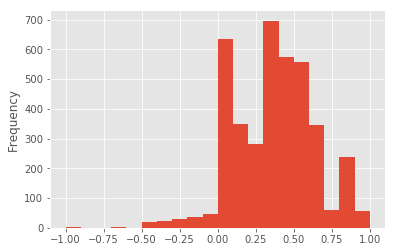

In [22]:
clean_comments['Sentiment polarity'].plot(kind='hist', bins=20)

### 3.2 Sentiment Analysis
We can convert the continuous polarity into discreate opinions, polarity < 0 is negative sentiment while polarity >= 0 is positive sentiment.

In [19]:
clean_comments['Sentiment output'] = clean_comments['Sentiment polarity'].apply(lambda s: 'pos' if s >= 0 else 'neg')

In [20]:
clean_comments.head(10)

,Device,Response ID,Time Started,Comment,Length,Sentiment polarity,Sentiment output
0,Msite,3058,2016-11-23 13:27:43,"Great variety of products, fast delivery,easy ...",11,0.500000,pos
1,Msite,3761,2016-12-03 12:54:00,fast delivery,2,0.200000,pos
2,Msite,4133,2016-12-08 00:04:50,Value for money No,4,0.000000,pos
3,Msite,4134,2016-12-08 00:34:02,Great customer service,3,0.800000,pos
4,Msite,4135,2016-12-08 01:00:43,Great service Return hasn't happened yet - jus...,20,0.150000,pos
6,Msite,4137,2016-12-08 02:30:14,Fast shipping,2,0.200000,pos
8,Msite,4139,2016-12-08 02:58:02,Great service and fast shipping It was my firs...,36,0.429762,pos
10,Msite,4141,2016-12-08 03:13:27,Ease of purchase,3,0.000000,pos
11,Msite,4142,2016-12-08 03:26:48,"Easy, quick.",2,0.383333,pos
14,Msite,4145,2016-12-08 03:40:41,"excellent, high quality products, quick delive...",38,0.412396,pos


And the distribution in terms of positive and negative sentiments is

In [142]:
clean_comments['Sentiment output'].value_counts()

pos    3789
neg     164
Name: Sentiment output 1, dtype: int64

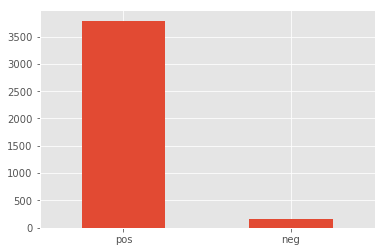

In [133]:
clean_comments['Sentiment output'].value_counts().plot(kind='bar', rot=0)

#### Let us do a spot check of some comments to see if it makes sense for positive or negative reviews.

In [23]:
clean_comments[clean_comments['Sentiment polarity'] > 0.2].head()

,Device,Response ID,Time Started,Comment,Length,Sentiment polarity,Sentiment output
0,Msite,3058,2016-11-23 13:27:43,"Great variety of products, fast delivery,easy ...",11,0.500000,pos
3,Msite,4134,2016-12-08 00:34:02,Great customer service,3,0.800000,pos
8,Msite,4139,2016-12-08 02:58:02,Great service and fast shipping It was my firs...,36,0.429762,pos
11,Msite,4142,2016-12-08 03:26:48,"Easy, quick.",2,0.383333,pos
14,Msite,4145,2016-12-08 03:40:41,"excellent, high quality products, quick delive...",38,0.412396,pos


In [24]:
clean_comments[clean_comments['Sentiment polarity'] < -0.2].head()

,Device,Response ID,Time Started,Comment,Length,Sentiment polarity,Sentiment output
202,Msite,4333,2016-12-12 12:43:18,Received wrong order and order out of stock,8,-0.500000,neg
272,Msite,4403,2016-12-13 08:20:13,Variety and service I haven't tried the app A...,38,-0.300000,neg
352,Msite,4483,2016-12-14 07:15:02,Sizes are very unpredictable,4,-0.216667,neg
425,Msite,4556,2016-12-15 19:43:12,Clothing terrible sizing.,3,-1.000000,neg
438,Msite,4569,2016-12-15 22:43:46,Failure to supply the goods and late advise of...,22,-0.308333,neg


Let us see what the sentiment is for the customer with the longest comments.

In [25]:
clean_comments.ix[lengthy_ix, :]

,Device,Response ID,Time Started,Comment,Length,Sentiment polarity,Sentiment output
5513,Desktop,74371,2017-01-03 07:21:00,Resealable pouch! free delivery easy returns I...,441,0.131784,pos


### 3.3 Save the results

In [29]:
raw_data.join(clean_comments, rsuffix='_2').to_csv("./sentiment_analysis_result.csv", header=False, index=False)

## 4. Conclusion and future work 

The above sentiment analysis is done based on a pre-defined sentiment database because the data provided don't have any labels (target varialable). It is expected to be less accurate comparing to the sentiment analysis models trained on a subset of data with labels. 

** To build a more accurate and robust Sentiment Analysis system, we should consider to train classification models based on supervised learning. That is a typical data science project workflow with repeatative steps as below. **

1. Obtain training data (e.g. through customer rating or manually annotating). 
*  Perform data processing and feature engineering. 
*  Build a classifier, evaluate and tune the model. 
*  Apply the model to predict unseen new data. 

** I have done a sentiment analysis for Amazon Fine Food Reviews which contains about 0.5 million comments by applying logistic regression and SVM and achieved decent results. Please refer to my [GitHub link](https://github.com/q15928/MDS/blob/master/Amazon%20Food%20Reviews_sentiment_analysis.ipynb) for more details.**


There are a few more things we can explore and research in order to improve the results.

* Regarding featrue engineering, besides bag-of-words, we can try TF-IDF (Term Frequency, Inverse Document Frequency), n-gram, POS (Part of Speech) tags, etc..
* We can try different classification models and algorithms, such as SVM, Decision Tree, Random Forest, XGBoost, etc..
* We can perform Sentiment Analysis for each individual question.